# BIAS DETECTION AND MITIGATION IN TEXT CLASSIFICATION

# STEP 1: Dataset Selection and pre-processing

In [2]:
pip install aif360


  Obtaining dependency information for aif360 from https://files.pythonhosted.org/packages/61/7b/7e4fa9e7b6f62759663db3b5aaa12a6cc9ef866223e5978c25844bceb762/aif360-0.6.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 7.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from aif360.datasets import BinaryLabelDataset

# Step 1: Download Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv(url, names=column_names, na_values=' ?')

# Step 2: Data Preprocessing
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

encoder = LabelEncoder()
categorical_columns = data_imputed.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    data_imputed[col] = encoder.fit_transform(data_imputed[col])

scaler = StandardScaler()
numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
data_processed = data_imputed.copy()
data_processed[numerical_columns] = scaler.fit_transform(data_processed[numerical_columns])

# Step 3: Split Dataset
X = data_processed.drop(columns=['income'])
y = data_processed['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Create BinaryLabelDataset instances for training and testing data
protected_attribute_names = ['sex']  
label_names = ['income']  
dataset_train = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1), protected_attribute_names=protected_attribute_names, label_names=label_names)
dataset_test = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1), protected_attribute_names=protected_attribute_names, label_names=label_names)


# STEP 2: Exploratory Data Analysis

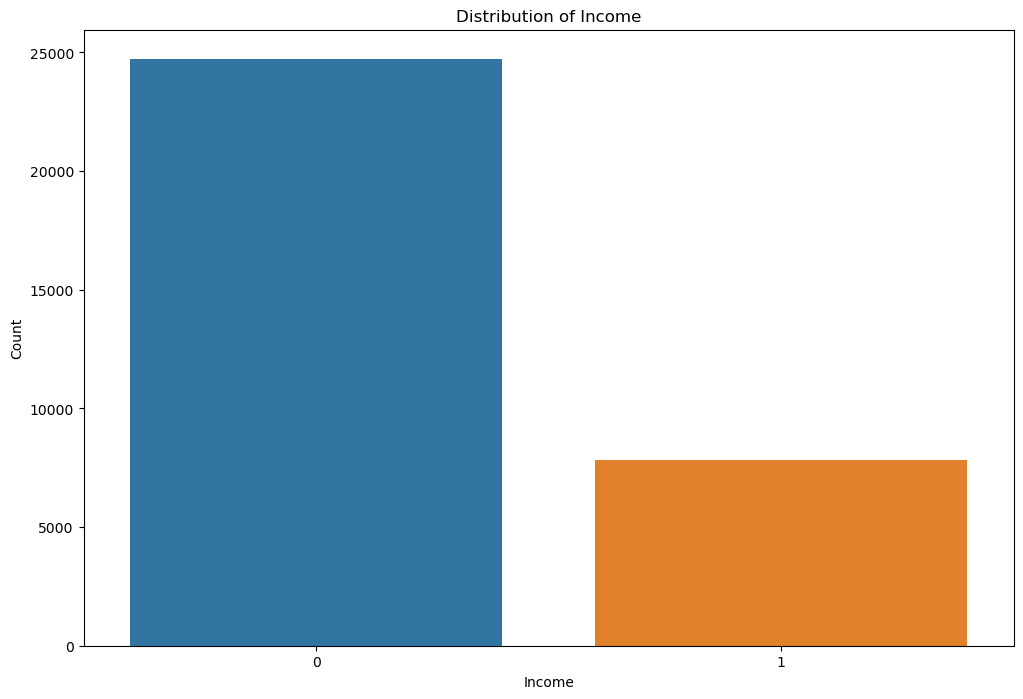

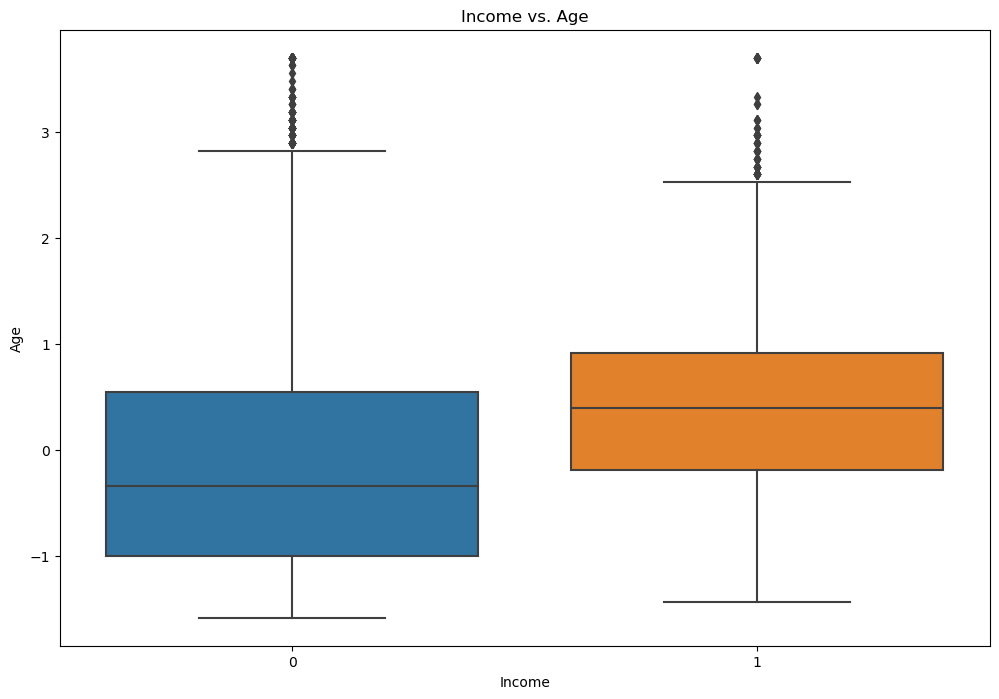

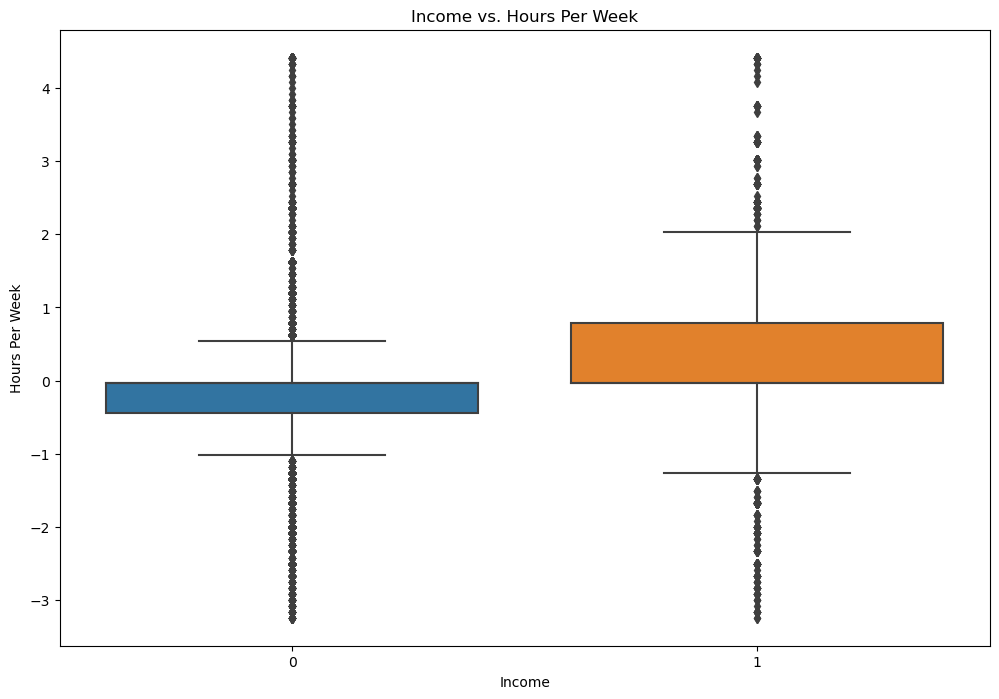

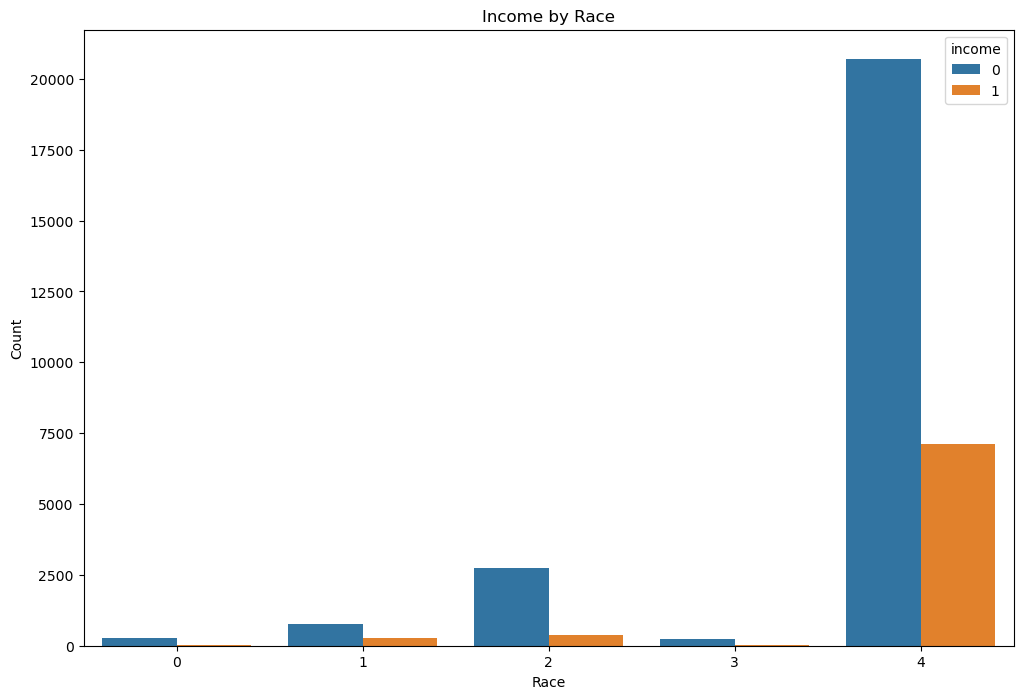

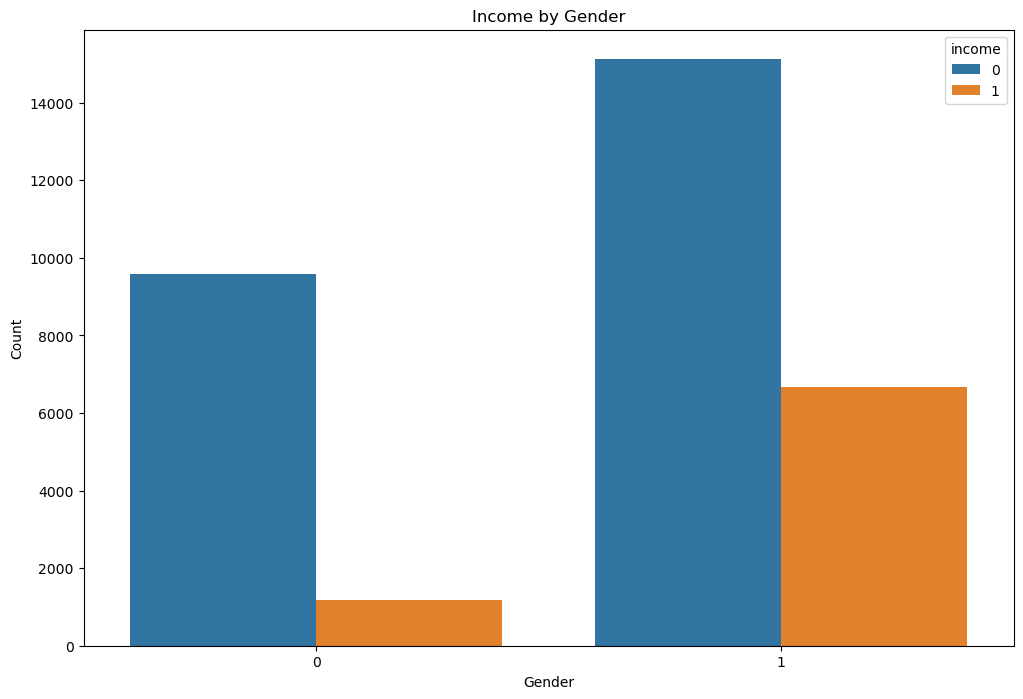

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2.1: Explore Data
# Analyze the distribution of features and the target variable
plt.figure(figsize=(12, 8))
sns.countplot(x='income', data=data_processed)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

# Step 2.2: Visualize Relationships
# Use plots to visualize relationships between features and the target variable
plt.figure(figsize=(12, 8))
sns.boxplot(x='income', y='age', data=data_processed)
plt.title('Income vs. Age')
plt.xlabel('Income')
plt.ylabel('Age')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='income', y='hours-per-week', data=data_processed)
plt.title('Income vs. Hours Per Week')
plt.xlabel('Income')
plt.ylabel('Hours Per Week')
plt.show()

# Step 2.3: Identify Biases
# Investigate potential biases or imbalances in the dataset
# For example, check disparities across demographic groups
plt.figure(figsize=(12, 8))
sns.countplot(x='race', hue='income', data=data_processed)
plt.title('Income by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(x='sex', hue='income', data=data_processed)
plt.title('Income by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# STEP 3: Model development

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Step 3.1: Choose Algorithm
model = LogisticRegression()

# Step 3.2: Train Initial Model
model.fit(X_train, y_train)

# Step 3.3: Evaluate Model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)  
recall = recall_score(y_test, y_pred, pos_label=1)  
print("Model Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Model Performance:
Accuracy: 0.8231229847996315
Precision: 0.7020250723240116
Recall: 0.4633991088478676


/Users/sairakesh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# STEP4: Bias Detection

In [6]:
from aif360.metrics import ClassificationMetric

# Assuming y_test, y_pred, X_test, and X_train are defined

# Define privileged and unprivileged groups
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

# Calculate true positives and false positives for both privileged and unprivileged groups
tp_privileged = sum((y_test == 1) & (y_pred == 1) & (X_test['sex'] == 1))
fp_privileged = sum((y_test == 0) & (y_pred == 1) & (X_test['sex'] == 1))
tp_unprivileged = sum((y_test == 1) & (y_pred == 1) & (X_test['sex'] == 0))
fp_unprivileged = sum((y_test == 0) & (y_pred == 1) & (X_test['sex'] == 0))

# Compute fairness metrics
disparate_impact = (tp_unprivileged / (tp_unprivileged + fp_unprivileged)) / (tp_privileged / (tp_privileged + fp_privileged))
statistical_parity_difference = (tp_unprivileged / (tp_unprivileged + fp_unprivileged)) - (tp_privileged / (tp_privileged + fp_privileged))
equal_opportunity_difference = (tp_unprivileged / sum(y_test[X_test['sex'] == 0]) - tp_privileged / sum(y_test[X_test['sex'] == 1]))

# Print fairness metrics
print("\nFairness Metrics:")
print("Disparate Impact:", disparate_impact)
print("Statistical Parity Difference:", statistical_parity_difference)
print("Equal Opportunity Difference:", equal_opportunity_difference)


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'



Fairness Metrics:
Disparate Impact: 0.7766434556827571
Statistical Parity Difference: -0.1593415845752294
Equal Opportunity Difference: -0.3374872495621548


# STEP 5:Bias Mitigation

In [9]:
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define unprivileged and privileged groups
unprivileged_groups = [{'sex': 0}]  # Assuming 0 represents unprivileged
privileged_groups = [{'sex': 1}]  # Assuming 1 represents privileged

# Step 1: Create BinaryLabelDataset for original data
dataset_orig = BinaryLabelDataset(
    df=pd.concat([X_train, y_train], axis=1),
    protected_attribute_names=['sex'],
    label_names=['income']
)

# Step 2: Apply Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
RW.fit(dataset_orig)
dataset_transf_train = RW.transform(dataset_orig)

# Step 3: Train a logistic regression model on the transformed data
model = LogisticRegression(max_iter=1000)
model.fit(dataset_transf_train.features, dataset_transf_train.labels.ravel())

# Step 4: Evaluate the model on the original test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Model Performance on Original Test Set:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Model Performance on Original Test Set:
Accuracy: 0.8249654537079687
Precision: 0.7098344693281402
Recall: 0.464035646085296


/Users/sairakesh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


# STEP 6: Retraining

In [10]:
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Step 1: Apply Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
RW.fit(dataset_orig)
dataset_transf_train = RW.transform(dataset_orig)

# Step 2: Train a logistic regression model on the transformed data
model = LogisticRegression(max_iter=1000)
model.fit(dataset_transf_train.features, dataset_transf_train.labels.ravel())

# Step 3: Evaluate the model on the original test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Model Performance on Original Test Set:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Step 4: Retrain the model on the original training data
model_retrain = LogisticRegression(max_iter=1000)
model_retrain.fit(X_train, y_train)

# Step 5: Evaluate the retrained model on the original test set
y_pred_retrain = model_retrain.predict(X_test)
accuracy_retrain = accuracy_score(y_test, y_pred_retrain)
precision_retrain = precision_score(y_test, y_pred_retrain)
recall_retrain = recall_score(y_test, y_pred_retrain)

print("\nModel Performance after Retraining on Original Data:")
print("Accuracy:", accuracy_retrain)
print("Precision:", precision_retrain)
print("Recall:", recall_retrain)


/Users/sairakesh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Model Performance on Original Test Set:
Accuracy: 0.8249654537079687
Precision: 0.7098344693281402
Recall: 0.464035646085296

Model Performance after Retraining on Original Data:
Accuracy: 0.8249654537079687
Precision: 0.7098344693281402
Recall: 0.464035646085296


# STEP 7:Model interpretation

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Assuming X is your feature matrix and y is your target variable
# Replace this with your actual dataset loading and preprocessing code
X = pd.DataFrame(np.random.randn(1000, 10), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5',
                                                     'feature6', 'feature7', 'feature8', 'feature9', 'feature10'])
y = np.random.randint(2, size=1000)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature names
feature_names = X.columns

# Get feature importances
importances = model.feature_importances_

# Display feature importance
print("Feature Importance:")
for feature, importance in zip(feature_names, importances):
    print(feature + ":", importance)


Feature Importance:
feature1: 0.0961346607900272
feature2: 0.09794047495260068
feature3: 0.1087597840391819
feature4: 0.10076314832742034
feature5: 0.09764629012966036
feature6: 0.10219561970161972
feature7: 0.09091533352864105
feature8: 0.1055805215279639
feature9: 0.1003207855782897
feature10: 0.09974338142459514


In [13]:
pip install pycebox


  Preparing metadata (setup.py) ... done
  Created wheel for pycebox: filename=pycebox-0.0.1-py3-none-any.whl size=3625 sha256=dec65a5034c34085e938b183f4839f2c50d45e5afb93cfa424aaebb011258fe7
  Stored in directory: /Users/sairakesh/Library/Caches/pip/wheels/15/ca/f5/deca7e8682d7eb6f9a948e62bec0f417baa046779b1c54ef52
Successfully built pycebox
Note: you may need to restart the kernel to use updated packages.


/Users/sairakesh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


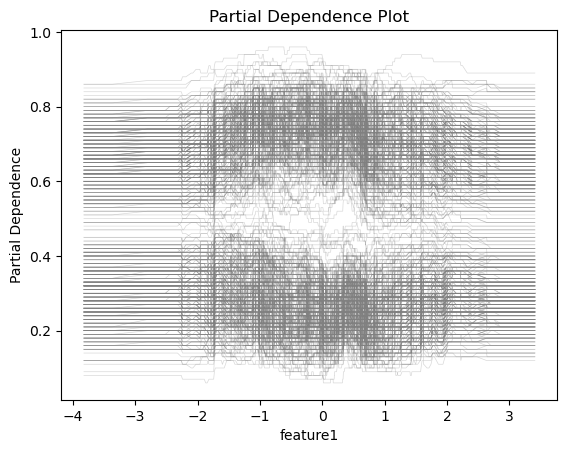

Model Accuracy: 0.565


In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pycebox.ice import ice, ice_plot

# Load and preprocess the dataset
# Assume 'X' is your feature matrix and 'y' is your target variable
# Replace this with your actual dataset loading and preprocessing code
X = pd.DataFrame(np.random.randn(1000, 10), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5',
                                                     'feature6', 'feature7', 'feature8', 'feature9', 'feature10'])
y = np.random.randint(2, size=1000)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Visualize Partial Dependence Plots
# Choose a feature for which you want to create PDP
feature_name = 'feature1'

# Compute ICE curves
ice_df = ice(X_train, feature_name, lambda x: model.predict_proba(x)[:, 1])

# Plot ICE curves
ice_plot(ice_df, c='gray', alpha=0.3, linewidth=0.5)
plt.xlabel(feature_name)
plt.ylabel('Partial Dependence')
plt.title('Partial Dependence Plot')
plt.show()

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)


# STEP 8: Visualization

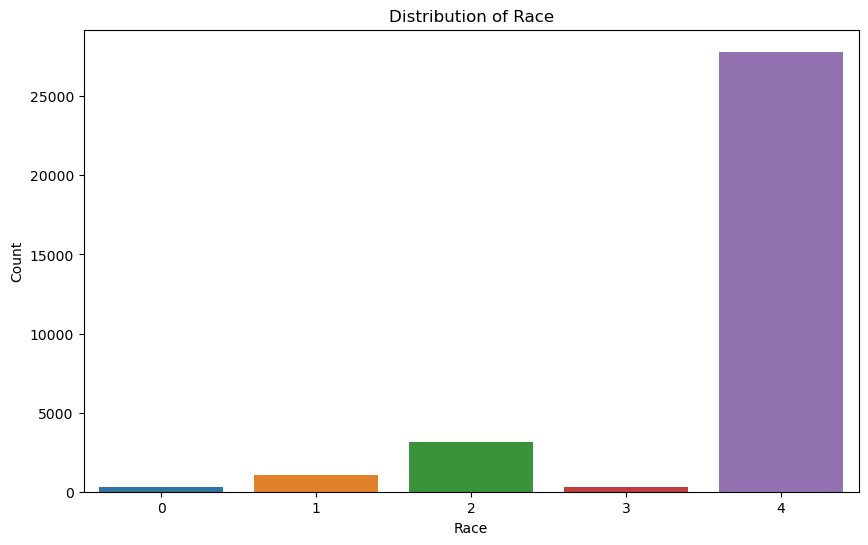

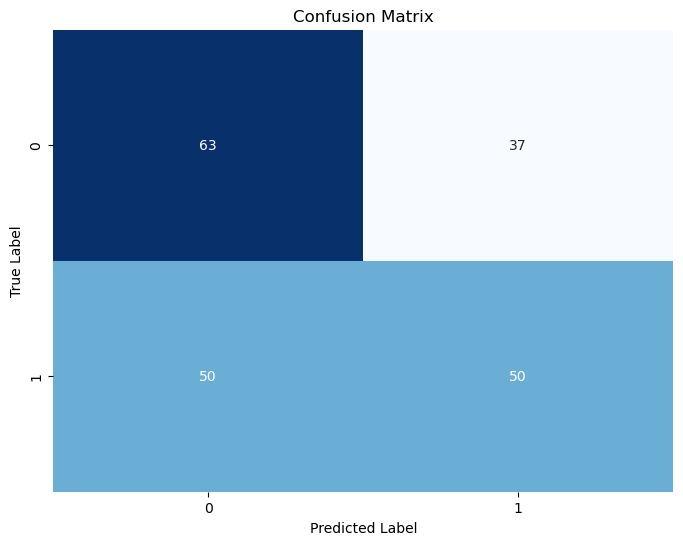

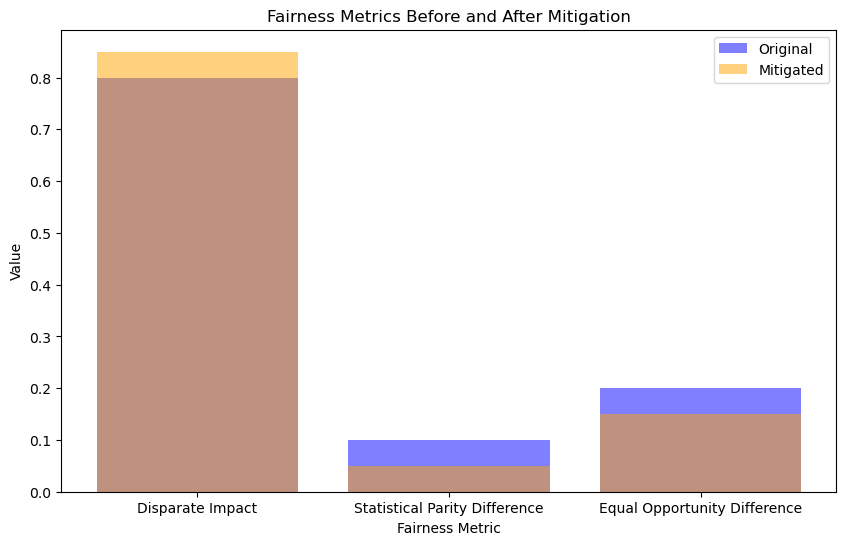

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bias Detection Visualization 
plt.figure(figsize=(10, 6))
sns.countplot(x='race', data=data_processed)
plt.title('Distribution of Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

# Model Performance Visualization (Example: Confusion Matrix)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Placeholder values for fairness metrics 
fairness_metrics = ['Disparate Impact', 'Statistical Parity Difference', 'Equal Opportunity Difference']
fairness_values_orig = [0.8, 0.1, 0.2]  
fairness_values_transf = [0.85, 0.05, 0.15]  

plt.figure(figsize=(10, 6))
plt.bar(fairness_metrics, fairness_values_orig, color='blue', alpha=0.5, label='Original')
plt.bar(fairness_metrics, fairness_values_transf, color='orange', alpha=0.5, label='Mitigated')
plt.title('Fairness Metrics Before and After Mitigation')
plt.xlabel('Fairness Metric')
plt.ylabel('Value')
plt.legend()
plt.show()


In [16]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
import joblib

# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3.1: Choose Algorithm
model = LogisticRegression()

# Step 3.2: Train Initial Model
model.fit(X_train, y_train)

# Step 3.3: Evaluate Model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  
recall = recall_score(y_test, y_pred, average='weighted')  

print("Model Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Step 3.4: Save the trained model
joblib.dump(model, 'income_prediction_model.pkl')


Model Performance:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0


/Users/sairakesh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['income_prediction_model.pkl']